# Viscoelasticity

**This is really cool. There's a simple boundary integral equation for layered linear viscoelasticity. I started working through the math thinking that I'd need to handle a volumetric term, but then I realized that the volumetric term reduces to just a boundary integral for the special case of layered viscoelasticity.**

## A layered viscoelastic PDE
Let's start from the constitutive equation for linear elasticity and the constitutive equation for a Maxwell viscoelastic rheology, both in antiplane strain:

\begin{align}
\textrm{Elastic:  }~~ \vec{\sigma} &= 2\mu\vec{\epsilon}\\
\textrm{Maxwell:  }~~ \dot{\vec{\sigma}} &= 2\mu\dot{\vec{\epsilon}} - \frac{\mu}{\eta}\vec{\sigma}
\end{align}

where $\vec{\sigma} = (\sigma_{xz}, \sigma_{yz})$ is the vector stress in the antiplane setting, $\mu$ is the shear modulus and $\eta$ is the viscosity.

We'll add the definition of strain, again in the antiplane setting:
\begin{equation}
\vec{\epsilon} = \frac{1}{2}\nabla u
\end{equation}

And Newton's law with a body force:
\begin{equation}
\nabla \cdot \vec{\sigma} = \vec{f}
\end{equation}

So, that for an elastic rheology, the result simplifies to the Laplace equation (or Poisson equation with zero right hand side). I'll carry the $2\mu$ through despite it dropping out because it will help later to understand the implementation.
\begin{align}
\nabla \cdot (2\mu \vec{\epsilon}) &= \vec{f} \\
2\mu \nabla^2 u &= \vec{f}
\end{align}

The result is a bit more complex for a Maxwell rheology. Ultimately though, we can still re-arrange the terms to make the result look like a Poisson equation with a funny looking right-hand-side. Inserting the Maxwell rheology equation into the time derivative of Newton's law:
\begin{align}
\nabla \cdot (2\mu\dot{\vec{\epsilon}} - \frac{\mu}{\eta}\vec{\sigma}) = 0\\
2\mu \nabla^2 \dot{u} = \nabla \cdot (\frac{\mu}{\eta}\vec{\sigma})
\end{align}

Let's explore that right hand side a bit more because the stress divergence component is going to drop out because the divergence of stress is zero.
\begin{align}
\nabla \cdot (\frac{\mu}{\eta}\vec{\sigma}) &= \nabla (\frac{\mu}{\eta}) \cdot \vec{\sigma} + \frac{\mu}{\eta} (\nabla \cdot \vec{\sigma})\\
&= \nabla (\frac{\mu}{\eta}) \cdot \vec{\sigma}
\end{align}

Now consider the figure below, a classic layered Maxwell viscoelastic half space where $\mu$ is constant and $\eta$ varies only as a step function across the elastic/viscoelastic boundary. As a result, the term that includes a viscosity divergence will simplify to:
\begin{equation}
\nabla (\frac{\mu}{\eta}) = (0, -\delta(y=D) \frac{\mu}{\eta_V})
\end{equation}

The negative is because inverse viscosity decreases in the positive y direction.

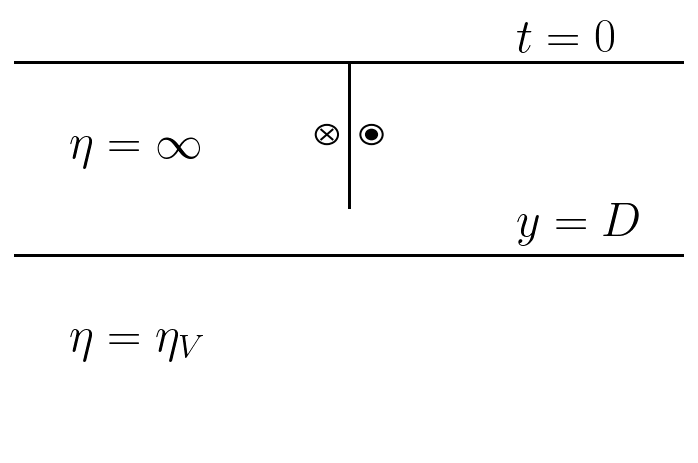

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["text.usetex"] = True
%config InlineBackend.figure_format='retina'

x = np.linspace(-1, 1, 100)
plt.plot(3 * x, 0 * x, "k-")
plt.plot(3 * x, -2 + 0 * x, "k-")
plt.plot(0 * x, -0.75 + 0.75 * x, "k-")
plt.text(-2.5, -1, "$\\eta = \\infty$", fontsize=24)
plt.text(-2.5, -3, "$\\eta = \\eta_V$", fontsize=24)
plt.text(1.5, 0.1, "$t = 0$", fontsize=24)
plt.text(1.5, -1.8, "$y = D$", fontsize=24)


plt.gca().add_patch(plt.Circle((0.2, -0.75), 0.10, color="k", fill=False))
plt.gca().add_patch(plt.Circle((0.2, -0.75), 0.05, color="k", fill=True))
plt.gca().add_patch(plt.Circle((-0.2, -0.75), 0.10, color="k", fill=False))
plt.plot([-0.25, -0.15], [-0.8, -0.7], "k-", linewidth=1)
plt.plot([-0.15, -0.25], [-0.8, -0.7], "k-", linewidth=1)

plt.xlim([-3, 3])
plt.ylim([-4, 0.5])
plt.axis("off")
plt.savefig("layered_ve.pdf")
plt.show()

So, the final equation we'd like to solve is:
\begin{equation}
2\mu \nabla^2 \frac{\partial u}{\partial t} = -\delta(y=D) \frac{\mu}{\eta_V} \sigma_y 
\end{equation}

In some situations, it can be more convenient to consider the equation in terms of the displacement rather than the velocity:
\begin{equation}
2\mu \nabla^2 u = -\delta(y=D) \frac{\mu}{\eta_V} \int_{0}^{T} \sigma_y dt
\end{equation}

## Viscoelastic boundary integral equation

Now, we'll transform the above equation into integral form. First, remember from the previous section that, when solving for the displacement resulting from a antiplane strike slip fault within a half space, the integral form was:

\begin{equation}
u(\mathbf{p}) = -\int_{H} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) u(\mathbf{q}) d\mathbf{q} -\int_{F} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) s(\mathbf{q}) d\mathbf{q} 
\end{equation}
where $\mathbf{p}$ is the observation point, $u$ is the displacement, $s$ is the slip on the fault, $H$ is the free surface, $F$ is the fault surface and $\frac{\partial G}{\partial n_q}$ is the kernel of the double layer potential. 

To extend this to a setting with a body force term, we can include the volume integral term:
\begin{equation}
u(\mathbf{p}) = -\int_{H} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) u(\mathbf{q}) d\mathbf{q} -\int_{F} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) s(\mathbf{q}) d\mathbf{q} + \int_{V} G(\mathbf{p},\mathbf{q}) f(\mathbf{q}) d\mathbf{q}
\end{equation}

Now, substituting in the body force from above for $f(\mathbf{q})$, the fascinating thing is that the delta function means that the volume integral will reduce to a surface integral over the surface $B$ that defines the boundary between the viscoelastic region and the elastic region. In our example, $B$ is defined by $y=D$.
\begin{equation}
\int_{V} G(\mathbf{p},\mathbf{q}) f(\mathbf{q}) d\mathbf{q} = -\frac{\mu}{\eta_V} \int_{B} G(\mathbf{p}, \mathbf{q}) \bigg[ \int_0^T \sigma_y(\mathbf{q}) dt \bigg] d\mathbf{q}
\end{equation}

So, the result is a purely boundary integral equation for the behavior of a fault in a viscoelastic and elastic layered space. 

\begin{equation}
u(\mathbf{p}) = -\int_{H} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) u(\mathbf{q}) d\mathbf{q} -\int_{F} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) s(\mathbf{q}) d\mathbf{q} - \int_{B} G(\mathbf{p}, \mathbf{q}) \bigg[\frac{\mu}{\eta_V} \int_0^T \sigma_y(\mathbf{q}) dt \bigg] d\mathbf{q}
\end{equation}

Assign $S$ as the stress integral:

\begin{equation}
S(\mathbf{q}) = \frac{\mu}{\eta_V} \int_0^T \sigma_y(\mathbf{q}) dt
\end{equation}

This integral equation results in a fairly simple time stepping algorithm where, given $S^n$.
1. Solve the BIE for $u$. 
2. Compute $\frac{\partial S(\mathbf{q})}{\partial t} = \sigma_y(\mathbf{q})$ for all $\mathbf{q} \in B$.
3. Compute $S^{n+1}$ according to the time integral.
4. Repeat for the next time step.

## Implementation

In [2]:
from config import setup, import_and_display_fnc

setup()

In [3]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from common import (
    gauss_rule,
    qbx_matrix,
    qbx_matrix2,
    qbx_setup,
    double_layer_matrix,
    hypersingular_matrix,
    stage1_refine,
    qbx_panel_setup,
    stage2_refine,
    pts_grid,
    apply_interp_mat,
)

First, we'll set up the problem geometry.

In [4]:
surf_half_L = 1000000
visco_half_L = 800000
corner_resolution = 5000
fault_bottom = 15000
visco_depth = 20000
shear_modulus = 3e10
viscosity = 5e18

qx, qw = gauss_rule(6)
t = sp.var("t")

control_points = [
    (0, 0, 0, corner_resolution),
    (0, -visco_depth, 0, corner_resolution),
]
fault, free, VB = stage1_refine(
    [
        (t, t * 0, fault_bottom * (t + 1) * -0.5),  # fault
        (t, -t * surf_half_L, 0 * t),  # free surface
        (t, -t * visco_half_L, -visco_depth + 0 * t),  # viscoelastic boundary
    ],
    (qx, qw),
    control_points=control_points,
)

fault_expansions, free_expansions, VB_expansions = qbx_panel_setup(
    [fault, free, VB], directions=[0, 1, 1], p=10
)

done after n_iterations=9 with n_panels=3
done after n_iterations=9 with n_panels=62
done after n_iterations=9 with n_panels=70


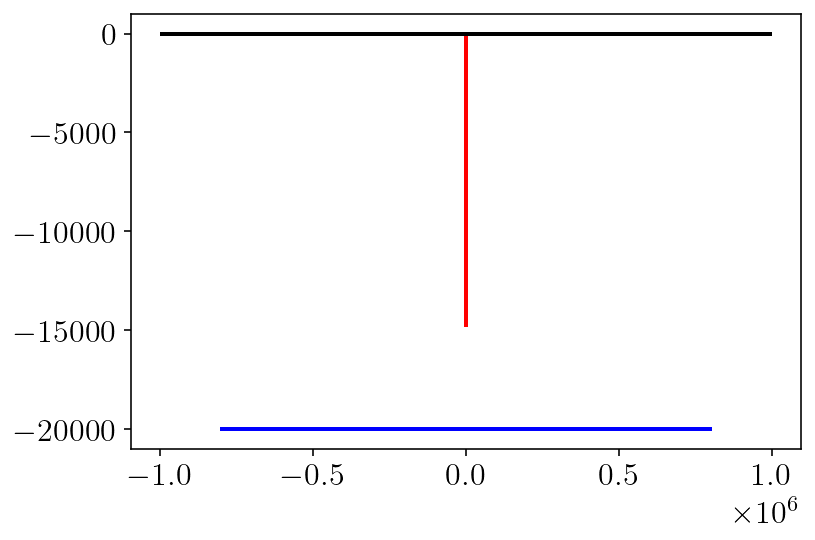

In [5]:
plt.plot(fault.pts[:,0], fault.pts[:,1], 'r-')
plt.plot(free.pts[:,0], free.pts[:, 1], 'k-')
plt.plot(VB.pts[:,0], VB.pts[:, 1], 'b-')
plt.show()

Here, we'll implement the series analytic solution for this problem from Segall 2008.

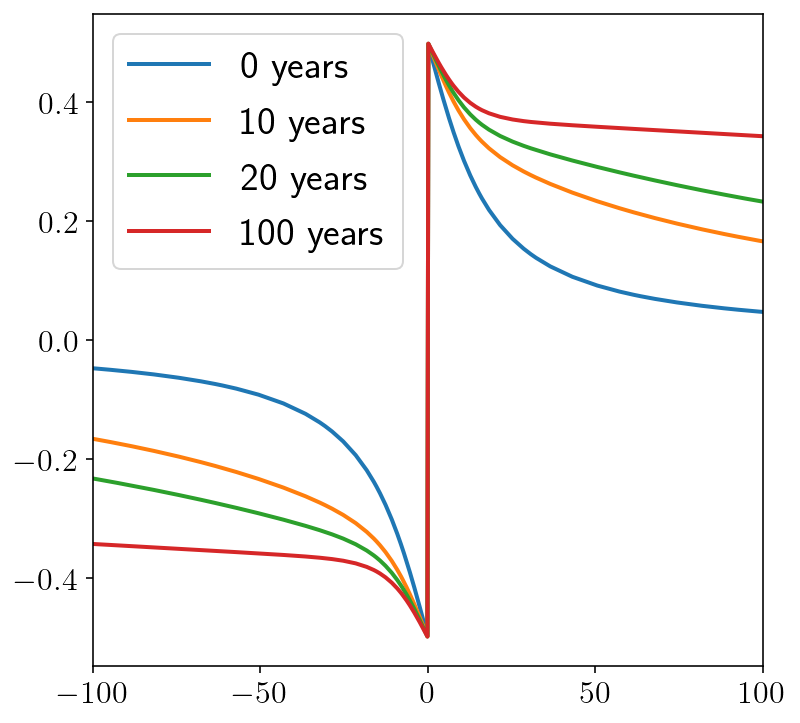

In [6]:
from math import factorial


def Fn(n, x, D, H):
    return np.arctan(2 * x * D / (x ** 2 + (2 * n * H) ** 2 - D ** 2))


def analytic_to_surface(slip, D, H, x, t):
    t_R = viscosity / shear_modulus
    C = slip / np.pi
    T1 = np.arctan(D / x)
    T2 = 0
    for n in range(1, 50):
        m_factor = 0
        for m in range(1, n + 1):
            m_factor += ((t / t_R) ** (n - m)) / factorial(n - m)
        n_factor = 1 - np.exp(-t / t_R) * m_factor
        T2 += n_factor * Fn(n, x, D, H)
    return C * (T1 + T2)


def analytic_soln(x, t):
    return analytic_to_surface(1.0, fault_bottom, visco_depth, x, t)


siay = 31556952
plt.figure(figsize=(6, 6))
for t in [0, 10.0 * siay, 20.0 * siay, 100.0 * siay]:
    plt.plot(
        free.pts[:, 0] / 1000.0,
        analytic_soln(free.pts[:, 0], t),
        label=f"{t/siay:.0f} years",
    )
plt.xlim([-100, 100])
plt.legend()
plt.show()

Next, in order to solve this problem, we'll need to more boundary integral operators. Previously, we've dealt with the double layer and the hypersingular operators. Here, we'll introduce the single layer and adjoint double layer operators. We can think of these operators in terms of their inputs and outputs:

(TODO: Make this into a little grid chart)
* single: potential gradient input, potential output $G(\mathbf{p}, \mathbf{q})$
* double: potential input, potential output: $\frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q})$
* adjoint double: potential gradient input, potential gradient output: $\frac{\partial G}{\partial n_p}(\mathbf{p}, \mathbf{q})$
* hypersingular: potential input, potential gradient output: $\frac{\partial G}{\partial n_q \partial n_p}(\mathbf{p}, \mathbf{q})$

In [7]:
import_and_display_fnc("common", "single_layer_matrix")
import_and_display_fnc("common", "adjoint_double_layer_matrix")

def single_layer_matrix(source, obs_pts):

    dx = obs_pts[:, 0, None] - source.pts[None, :, 0]
    dy = obs_pts[:, 1, None] - source.pts[None, :, 1]
    r2 = dx ** 2 + dy ** 2
    G = (1.0 / (4 * np.pi)) * np.log(r2)

    return (G * source.jacobians * source.quad_wts[None, :])[:, None, :]

def adjoint_double_layer_matrix(source, obs_pts):
    dx = obs_pts[:, None, 0] - source.pts[None, :, 0]
    dy = obs_pts[:, None, 1] - source.pts[None, :, 1]
    r2 = dx ** 2 + dy ** 2

    out = np.empty((obs_pts.shape[0], 2, source.n_pts))
    out[:, 0, :] = dx
    out[:, 1, :] = dy

    C = -1.0 / (2 * np.pi * r2)

    # multiply by the scaling factor, jacobian and quadrature weights
    return out * (C * (source.jacobians * source.quad_wts[None, :]))[:, None, :]

There are two boundary integral equations that we need to compute the terms of:
1. The equation to solve for free surface displacement given the fault slip and the stress integral $S(q)$.

\begin{equation}
u(\mathbf{p}) + \int_{H} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) u(\mathbf{q}) d\mathbf{q} = -\int_{F} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) s(\mathbf{q}) d\mathbf{q} - \frac{1}{\mu}\int_{B} G(\mathbf{p}, \mathbf{q}) S(\mathbf{q}) d\mathbf{q}
\end{equation}

I'll note these terms as `{src_surf}_to_free_disp`. We'll construct the inverted left hand side matrix in `free_disp_solve_mat_inv`. 

In [8]:
free_disp_to_free_disp = qbx_matrix2(
    double_layer_matrix, free, free.pts, free_expansions
)[:, 0, :]
fault_slip_to_free_disp = -qbx_matrix2(
    double_layer_matrix, fault, free.pts, free_expansions
)[:, 0, :]
VB_S_to_free_disp = (1.0 / shear_modulus) * qbx_matrix2(
    single_layer_matrix, VB, free.pts, free_expansions
)[:, 0, :]

free_disp_solve_mat = np.eye(free_disp_to_free_disp.shape[0]) + free_disp_to_free_disp
free_disp_solve_mat_inv = np.linalg.inv(free_disp_solve_mat)

slip = np.ones(fault.n_pts)

2. The equation to solve for the stress on the viscoelastic boundary surface. 

\begin{equation}
\vec{\sigma}(\mathbf{p}) = -\mu\int_{H} \frac{\partial G}{\partial n_q \partial n_p}(\mathbf{p}, \mathbf{q}) u(\mathbf{q}) d\mathbf{q} -\mu\int_{F} \frac{\partial G}{\partial n_q \partial n_p}(\mathbf{p}, \mathbf{q}) s(\mathbf{q}) d\mathbf{q} - \int_{B} \frac{\partial G}{\partial n_p} S(\mathbf{q})  d\mathbf{q}
\end{equation}

In [9]:
free_disp_to_VB_syz = (
    shear_modulus
    * qbx_matrix2(hypersingular_matrix, free, VB.pts, VB_expansions)[:, 1, :]
)
fault_slip_to_VB_syz = (
    shear_modulus
    * qbx_matrix2(hypersingular_matrix, fault, VB.pts, VB_expansions)[:, 1, :]
)
VB_S_to_VB_syz = qbx_matrix2(
    adjoint_double_layer_matrix, VB, VB.pts, VB_expansions
)[:, 1, :]

In [10]:
%%time
# The slip does not change so these two integral terms can remain
# outside the time stepping loop.
syz_fault = fault_slip_to_VB_syz.dot(slip)
rhs_slip = fault_slip_to_free_disp.dot(slip)

# We'll integrate for 100 years of time in steps of 0.01 years. 
# siay is "seconds in a year".
n_steps = 10001
dt = 0.01 * siay

stress_integral = np.zeros(VB.n_pts)
t = 0
t_history = []
disp_history = []
S_history = []
for i in range(n_steps):
    # Step 1) Solve for free surface displacement.
    rhs = rhs_slip + VB_S_to_free_disp.dot(stress_integral)
    free_disp = free_disp_solve_mat_inv.dot(rhs)

    t_history.append(t)
    disp_history.append(free_disp)
    S_history.append(stress_integral.copy())

    # Step 2): Calculate viscoelastic boundary stress yz component and then d[S]/dt
    syz_free = free_disp_to_VB_syz.dot(free_disp)
    syz_VB = VB_S_to_VB_syz.dot(stress_integral)
    syz_full = 2 * (syz_free + syz_fault + syz_VB)
    dSdt = -(shear_modulus / viscosity) * syz_full

    # Step 3): Update S, simple forward Euler time step.
    stress_integral += dSdt * dt
    t += dt
t_history = np.array(t_history)

CPU times: user 13.4 s, sys: 8.87 s, total: 22.3 s
Wall time: 3.73 s


In [11]:
# Numerically differentiate to obtain velocities.
velocity = siay * np.diff(np.array(disp_history), axis=0) / np.diff(t_history)[:, None]

## Comparison against the analytic solution.

The first and second plots below show the numerical solution against the analytic solution. We can see that the error rises over time. Further investigation will demonstrate that this error is completely dominated by the error from truncating the infinite surfaces in the analytic problem into finite surfaces here. 

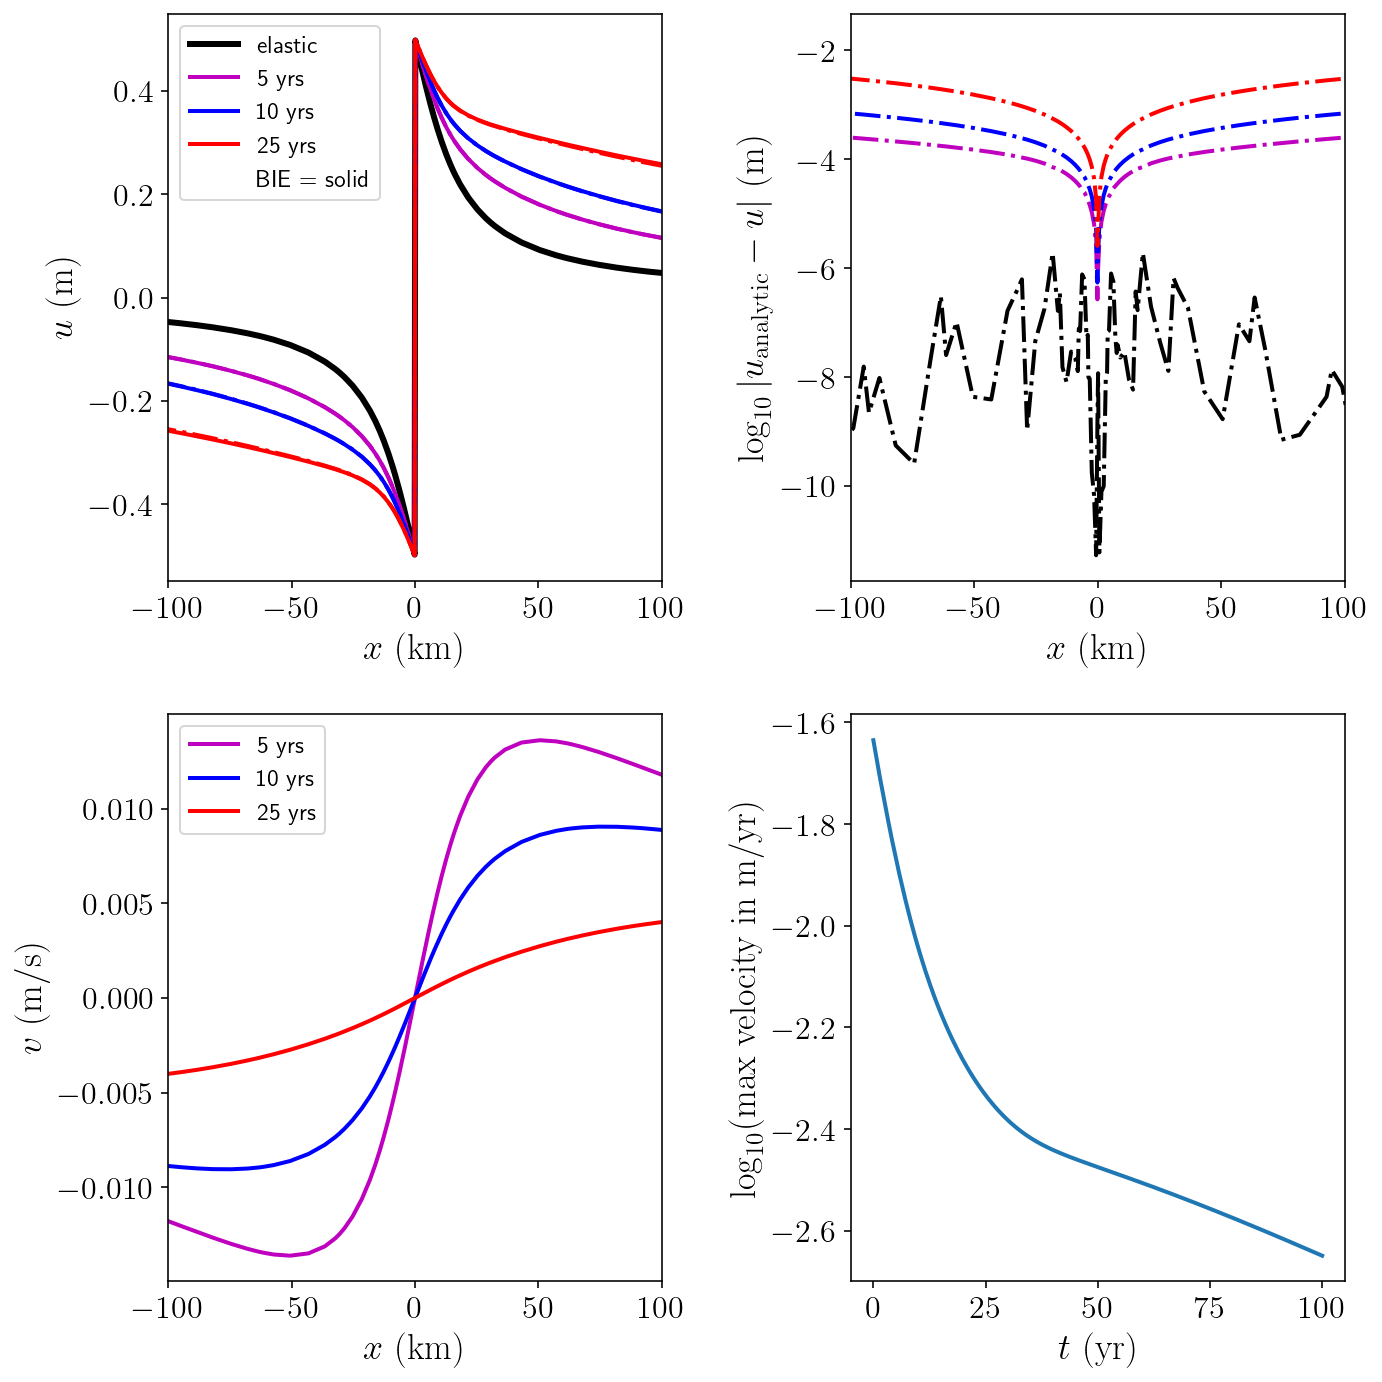

In [12]:
plt.figure(figsize=(10, 10))
X = free.pts[:, 0] / 1000

plt.subplot(2, 2, 1)
plt.plot(X, disp_history[0], "k-", linewidth=3, label="elastic")
steps_to_plt = [("m", 500, 5), ("b", 1000, 10), ("r", 2500, 25)]
for color, i, yr in steps_to_plt:
    plt.plot(X, disp_history[i], color + "-", label=str(yr) + " yrs")
    plt.plot(X, analytic_soln(free.pts[:, 0], t_history[i]), color + "-.")
plt.plot([], [], " ", label="BIE = solid")
plt.xlim([-100, 100])
plt.xlabel(r"$x ~ \mathrm{(km)}$")
plt.ylabel(r"$u ~ \mathrm{(m)}$")
plt.legend(loc="upper left", fontsize=12)

plt.subplot(2, 2, 2)
for color, i, yr in [("k", 0, 0)] + steps_to_plt:
    analytic = analytic_soln(free.pts[:, 0], t_history[i])
    numerical = disp_history[i]
    diff = analytic - numerical
    plt.plot(X, np.log10(np.abs(diff)), color + "-.")
plt.xlim([-100, 100])
plt.xlabel(r"$x ~ \mathrm{(km)}$")
plt.ylabel(r"$\log_{10}{|u_{\textrm{analytic}} - u|} ~ \mathrm{(m)}$")

plt.subplot(2, 2, 3)
for color, i, yr in steps_to_plt:
    plt.plot(X, velocity[i], color + "-", label=str(yr) + " yrs")
plt.xlim([-100, 100])
plt.xlabel(r"$x ~ \mathrm{(km)}$")
plt.ylabel(r"$v ~ \mathrm{(m/s)}$")
plt.legend(fontsize=12)

plt.subplot(2, 2, 4)
plt.plot(t_history[1:] / siay, np.log10(np.max(np.abs(velocity), axis=1)))
plt.xlabel(r"$t ~ (\textrm{yr})$")
plt.ylabel(r"$\log_{10}(\textrm{max velocity in m/yr})$")

plt.tight_layout()
plt.show()

# TODO:

- Why is the max velocity going back up after 30 years? It wasn't doing that before. What did I break?
    - This was only happening when I had the longer VB surface or maybe the longer free surface.
    - This might be due to some kind of QBX expansion center issue at the tips of the VB surface.
- Why does using a subset of the expansions for any given boundary integral operator evaluation give me the wrong answer? 
  - It doesn't!!! 
  - Doing this correctly gives the best answer possible and solves the above problem with max velocity increasing after 30 years. Getting all the math right is always such a wonderful thing!!
  - However, there's a really interesting lesson here. All the terms in a BIE seem to need to be evaluated at the *same* interior points. In other words, for every observation point, it's important to always use the same expansion center. 
  - An interesting consequence of this might be that the observation points themselves should be assigned to expansion centers or otherwise somehow linked in the software design?
- Why is there a factor of two in the viscoelastic stress-equivalent update? 
  - My current best guess here is that the equation for the stress on the VB boundary is $\frac{\sigma}{2} = \textrm{syz_full}$ - That would introduce the expected factor of two and would possibly result from a limit to the boundary process?
- A handy debugging tool would be a function that returns the expansion center for each observation point. Is there a way to refactor so that this is easy?
- There's **STILL** something broken when I increase the length of the VB surface to be equal to that of the free surface.
  - Could it be from the singularities created by the tips of the free surface and I should avoid having those interact with the VB surface? This seems to be corroborated by the fact that making the VB surface a bit shorter results in no problems.

# EXTRA

In [13]:
asd

NameError: name 'asd' is not defined

In [ ]:
plt.plot(fault.pts[:, 0], fault.pts[:, 1], "r-o")
plt.plot(fault_stage2.pts[:, 0], fault_stage2.pts[:, 1], "r*")
plt.plot(free_stage2.pts[:, 0], free_stage2.pts[:, 1], "k-o")
plt.plot(VB_stage2.pts[:, 0], VB_stage2.pts[:, 1], "k-o")
plt.plot(expansions.pts[:, 0], expansions.pts[:, 1], "bo")

window = [(-500, 500), (-20500, -19500)]
window_center = np.mean(window, axis=1)
window_R = np.sqrt(np.sum(np.max(np.abs(window - window_center[:, None]), axis=1) ** 2))
dist_from_window = np.sqrt(np.sum((expansions.pts - window_center) ** 2, axis=1))
should_plot_expansion = dist_from_window < (expansions.r + window_R)
plot_expansions_pts = expansions.pts[should_plot_expansion]
plot_expansions_r = expansions.r[should_plot_expansion]
for i in range(plot_expansions_pts.shape[0]):
    plt.gca().add_patch(
        plt.Circle(plot_expansions_pts[i], plot_expansions_r[i], color="b", fill=False)
    )

plt.xlim(window[0])
plt.ylim(window[1])
plt.show()

In [ ]:
nobs = 150
zoomx = [-15000, 15000]
zoomy = [-31000, -1000]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obs_pts = pts_grid(xs, ys)
obsx = obs_pts[:, 0].reshape((nobs, nobs))
obsy = obs_pts[:, 1].reshape((nobs, nobs))

In [ ]:
free_disp_to_volume_disp = apply_interp_mat(
    qbx_matrix(double_layer_matrix, free_stage2, obs_pts, expansions), free_interp_mat
)
fault_slip_to_volume_disp = qbx_matrix(
    double_layer_matrix, fault_stage2, obs_pts, expansions
)
VB_S_to_volume_disp = (1.0 / shear_modulus) * apply_interp_mat(
    qbx_matrix(single_layer_matrix, VB_stage2, obs_pts, expansions), VB_interp_mat
)

free_disp_to_volume_stress = shear_modulus * apply_interp_mat(
    qbx_matrix(hypersingular_matrix, free_stage2, obs_pts, expansions), free_interp_mat
)
fault_slip_to_volume_stress = shear_modulus * qbx_matrix(
    hypersingular_matrix, fault_stage2, obs_pts, expansions
)
VB_S_to_volume_stress = apply_interp_mat(
    qbx_matrix(adjoint_double_layer_matrix, VB_stage2, obs_pts, expansions),
    VB_interp_mat,
)


def get_volumetric_disp(free_disp, slip, stress_integral):
    disp_free = free_disp_to_volume_disp.dot(free_disp)
    disp_fault = fault_slip_to_volume_disp.dot(slip)
    disp_VB = VB_S_to_volume_disp.dot(stress_integral)
    return (disp_free + disp_fault + disp_VB).reshape(obsx.shape)


def get_volumetric_stress(free_disp, slip, stress_integral):
    stress_free = free_disp_to_volume_stress.dot(free_disp)
    stress_fault = fault_slip_to_volume_stress.dot(slip)
    stress_VB = VB_S_to_volume_stress.dot(stress_integral)

    return (stress_free + stress_fault + stress_VB).reshape((*obsx.shape, 2))


def simple_plot(field, levels):
    n_dims = field.shape[2]
    plt.figure(figsize=(4 * n_dims, 4))
    for d in range(field.shape[2]):
        plt.subplot(1, n_dims, 1 + d)
        cntf = plt.contourf(
            obsx, obsy, field[:, :, d], levels=levels, extend="both", cmap="RdBu_r"
        )
        plt.contour(
            obsx,
            obsy,
            field[:, :, d],
            colors="k",
            linestyles="-",
            linewidths=0.5,
            levels=levels,
            extend="both",
        )
        plt.plot(free.pts[:, 0], free.pts[:, 1], "k-", linewidth=1.5)
        plt.plot(fault.pts[:, 0], fault.pts[:, 1], "k-", linewidth=1.5)
        plt.colorbar(cntf)
        plt.xlim(zoomx)
        plt.ylim(zoomy)
    plt.tight_layout()
    plt.show()

In [ ]:
# slip_tapered = 1.0 + np.cos(
#     np.pi * (np.minimum(fault_stage2.pts[:, 1], -5000) + 5000) / 10000
# )  # np.minimum(np.ones_like(slip), np.exp(0.01 * (fault.pts[:,1] + 10000)))
slip_tapered = 1.0 / (1 + np.exp(-(fault_stage2.pts[:, 1] + 11000) / 1000.0))
plt.plot(fault_stage2.pts[:, 1], slip_tapered, "b-*")
plt.show()

In [ ]:
for terms in [(1, 0, 0), (0, 1, 0), (0, 0, 1)]:
    disp = get_volumetric_disp(
        terms[0] * free_disp, terms[1] * slip_tapered, terms[2] * stress_integral
    )
    simple_plot(disp[:, :, None], None)

In [ ]:
for terms in [(1, 0, 0), (0, 1, 0), (0, 0, 1)]:
    stress = get_volumetric_stress(
        terms[0] * free_disp, terms[1] * slip_tapered, terms[2] * stress_integral
    )
    levels = np.linspace(-1e6, 1e6, 21)
    simple_plot(stress, levels)